In [1]:
from google.colab import files
files.upload()

Saving apple.csv to apple.csv
Saving cmcst.csv to cmcst.csv
Saving google.csv to google.csv
Saving qcom.csv to qcom.csv


{'apple.csv': b'147.05,145.52,147.49,144.27\n147.51,147.54,148.09,146.84\n146.58,145.1,147.2,144.96\n143.65,144.09,144.3,143.27\n143.79,143.923,144.16,143.31\n143.68,144.47,144.6,143.3762\n144.53,143.91,144.9,143.87\n143.64,143.5,143.95,143.18\n142.27,142.44,142.68,141.85\n142.44,141.22,142.92,141.16\n140.68,141.88,142,140.45\n141.2,141.41,142.04,141.11\n141.83,141.48,141.88,140.87\n141.05,141.91,142.38,141.05\n141.8,141.6,142.15,141.01\n141.63,142.94,143.35,140.06\n143.17,143.6,143.8792,142.9\n143.34,143.73,144.18,143.27\n143.66,144.29,144.52,143.45\n144.02,144.22,145.46,143.81\n144.77,143.25,144.89,143.17\n143.7,143.71,144.12,143.05\n143.66,143.72,144.27,143.01\n143.93,144.19,144.5,143.5\n144.12,143.68,144.49,143.19\n143.8,140.91,144.04,140.62\n140.88,139.39,141.22,138.62\n140.64,141.5,141.74,140.35\n140.92,141.26,141.5844,140.61\n141.42,139.845,141.6,139.76\n139.84,142.11,142.8,139.73\n141.46,140.4,141.5,140.23\n139.99,141,141,139.89\n140.69,140.72,141.02,140.26\n140.46,139.41,140.7

Optimum number of states are 13
MAPE for the stock apple.csv is  [0.00862423 0.00928036 0.00801314 0.00791642]


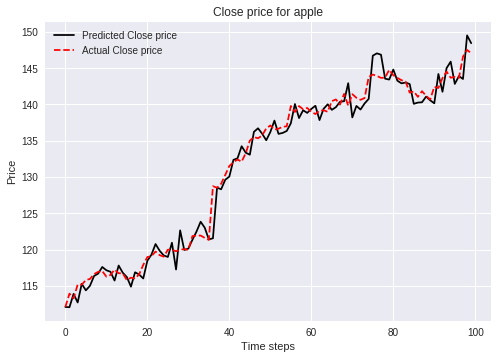

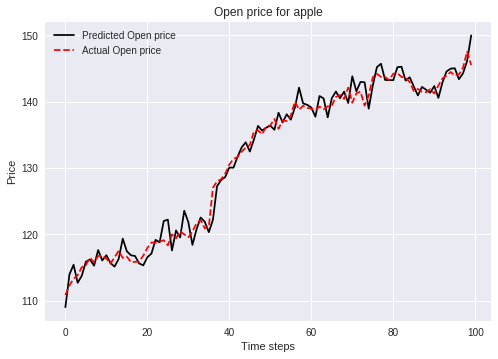

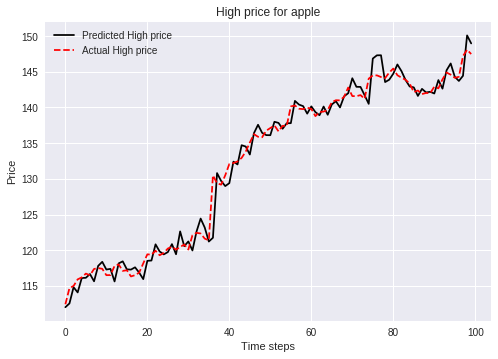

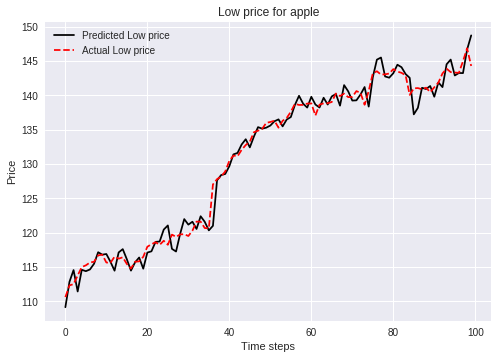

Optimum number of states are 14
MAPE for the stock cmcst.csv is  [0.00967636 0.01030186 0.00919724 0.00883633]


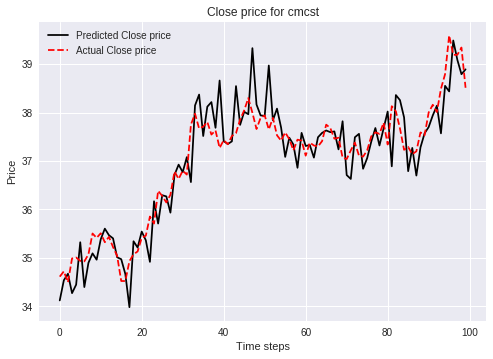

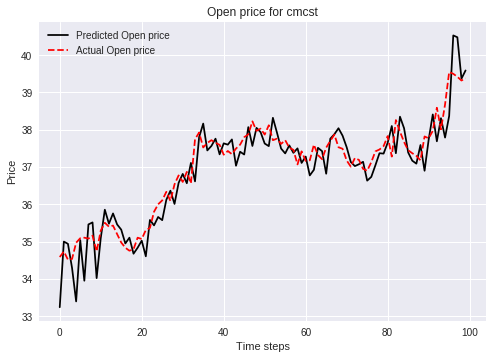

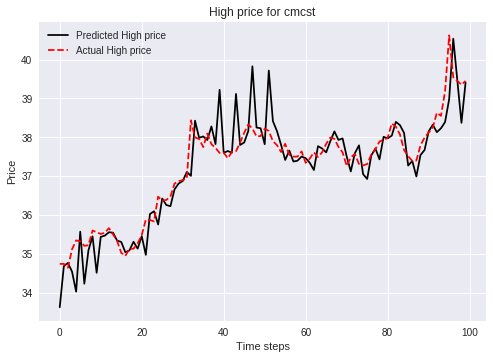

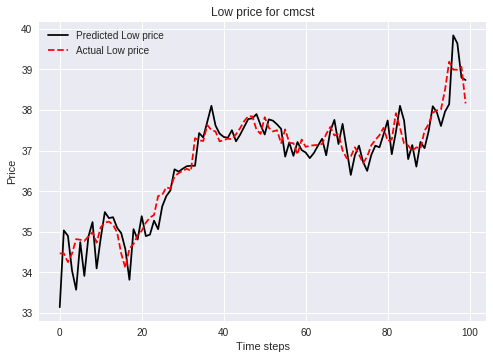

Optimum number of states are 13
MAPE for the stock google.csv is  [0.00903117 0.01011407 0.01006171 0.00943624]


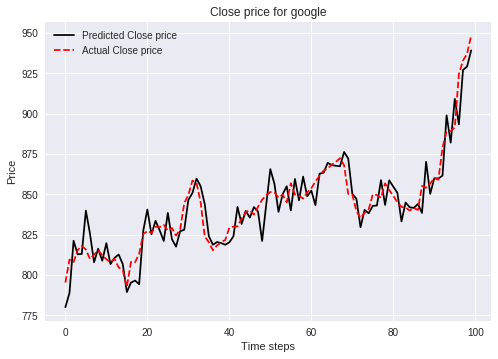

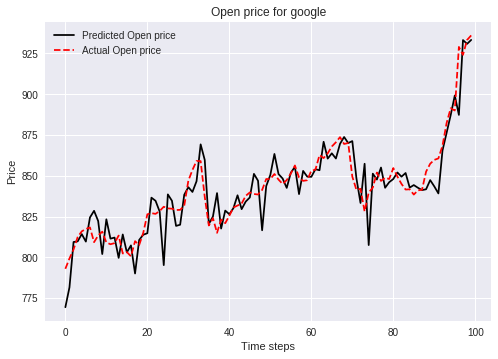

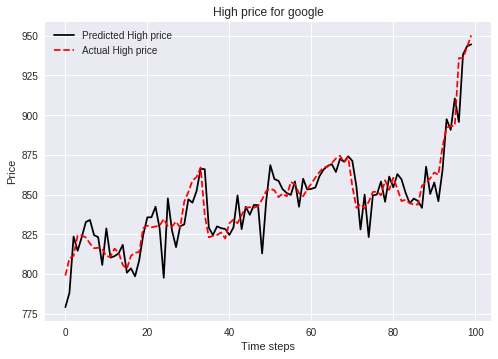

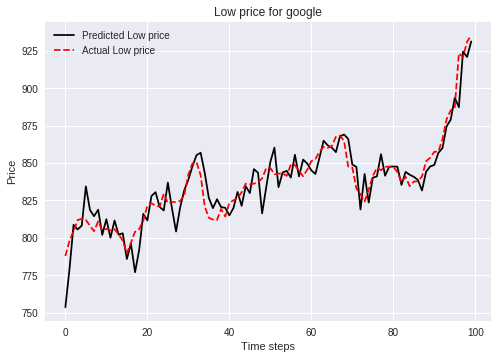

Optimum number of states are 13
MAPE for the stock qcom.csv is  [0.01689512 0.01492756 0.01457583 0.01741513]


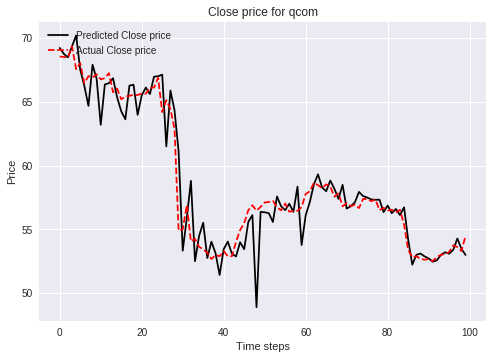

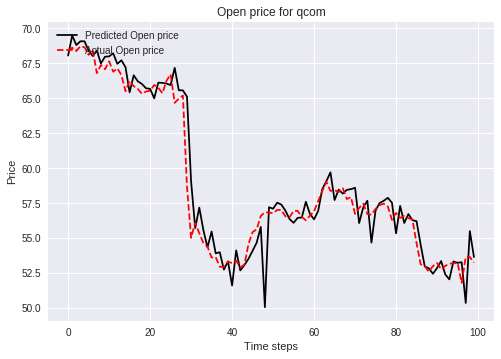

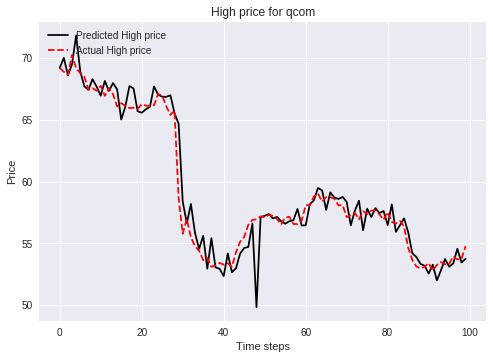

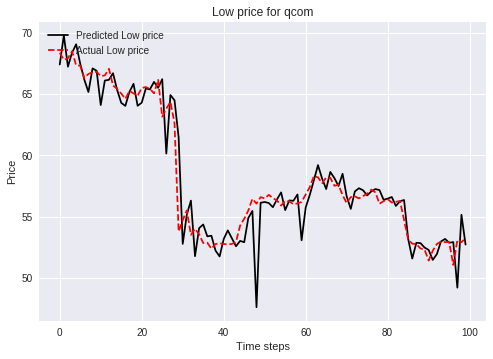

In [2]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

PLOT_SHOW=True
PLOT_TYPE = False

NUM_TEST = 100
K = 50
NUM_ITERS=10000

STOCKS=['apple.csv','cmcst.csv','google.csv','qcom.csv']
#NUM_STATES=12
#FILE_NAME='HistoricalQuotes.csv'
#TRAIN_CHUNK_SIZE=100

#dirichlet_params = np.array([1., 20., 20., 20.])
#dirichlet_params = np.random.randint(1,50,NUM_STATES)
labels = ['Close','Open','High','Low']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(2,15)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])


for stock in STOCKS:
    dataset = np.genfromtxt(stock, delimiter=',')
    predicted_stock_data = np.empty([0,dataset.shape[1]])
    likelihood_vect = np.empty([0,1])
    aic_vect = np.empty([0,1])
    bic_vect = np.empty([0,1])
    for states in STATE_SPACE:
        num_params = states**2 + states
        dirichlet_params_states = np.random.randint(1,50,states)
        #model = hmm.GaussianHMM(n_components=states, covariance_type='full', startprob_prior=dirichlet_params_states, transmat_prior=dirichlet_params_states, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(dataset[NUM_TEST:,:])
        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
        aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
        bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))
    
    opt_states = np.argmin(bic_vect) + 2
    print('Optimum number of states are {}'.format(opt_states))

    for idx in reversed(range(NUM_TEST)):
        train_dataset = dataset[idx + 1:,:]
        test_data = dataset[idx,:]; 
        num_examples = train_dataset.shape[0]
        #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            # Retune the model by using the HMM paramters from the previous iterations as the prior
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior 
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))

        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        #print('Model score : ', model.score(dataset))
        #print('Dirichlet parameters : ',dirichlet_params)

        iters = 1;
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters = iters + 1
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
        predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))
    np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')

    mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
    print('MAPE for the stock {} is '.format(stock),mape)

    if PLOT_TYPE:
        hdl_p = plt.plot(range(100), predicted_stock_data);
        plt.title('Predicted stock prices')
        plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.figure()
        hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
        plt.title('Actual stock prices')
        plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
    else:
        for i in range(4):
            plt.figure()
            plt.plot(range(100), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price');
            plt.plot(range(100),np.flipud(dataset[range(100),i]),'r--', label = 'Actual '+labels[i]+' price')
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title(labels[i]+' price'+ ' for '+stock[:-4])
            plt.grid(True)
            plt.legend(loc = 'upper left')
        

    if PLOT_SHOW:
        plt.show(block=False)
